In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import time
from tqdm import tqdm
from path_explain.path_explainer_tf import PathExplainerTF

In [4]:
baseline = np.random.randn(1000, 10)
inputs = np.random.randn(50, 10)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(10, dtype=tf.float32))
model.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.softplus, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [8]:
explainer = PathExplainerTF(model)

In [9]:
current_alphas = explainer._sample_alphas(num_samples=100, use_expectation=True, use_product=True)
interactions = explainer._single_interaction(inputs[0], baseline,
                              current_alphas, num_samples=100, batch_size=50,
                              use_expectation=True, output_index=None,
                              interaction_index=None)
assert interactions.shape == (10, 10)

## Testing Shape
We need to make sure our attributions return an array of the right shape.

In [10]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=0)
assert interactions.shape == (50, 10)

100%|██████████| 50/50 [00:00<00:00, 216.32it/s]


In [11]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=None)
assert interactions.shape == (50, 10, 10)

100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


## Testing completeness
We need to make sure our interactions satisfy completeness!

In [12]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=None)

100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


In [14]:
attributions = explainer.attributions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True)


100%|██████████| 50/50 [00:00<00:00, 310.04it/s]


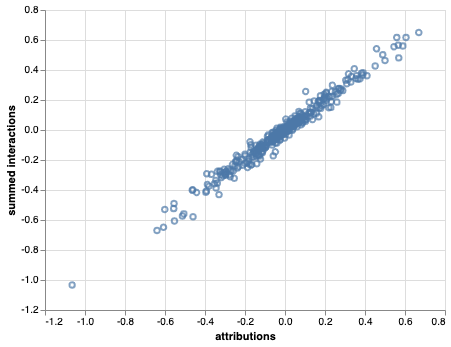

In [15]:
summed_interactions = np.sum(interactions, axis=1)
data_df = pd.DataFrame({
    'attributions': attributions.flatten(),
    'summed interactions': summed_interactions.flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('attributions:Q'),
    alt.Y('summed interactions:Q')
)

In [16]:
batch_sizes = np.linspace(10, 200, 20).astype(int)
times = []
for batch_size in tqdm(batch_sizes):
    start_time = time.time()
    interactions = explainer.interactions(inputs, baseline,
                     batch_size=batch_size, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=False, interaction_index=None)
    end_time = time.time()
    times.append(end_time - start_time)
    assert interactions.shape == (50, 10, 10), 'batch_size: {}'.format(batch_size)

100%|██████████| 20/20 [03:54<00:00, 11.74s/it]


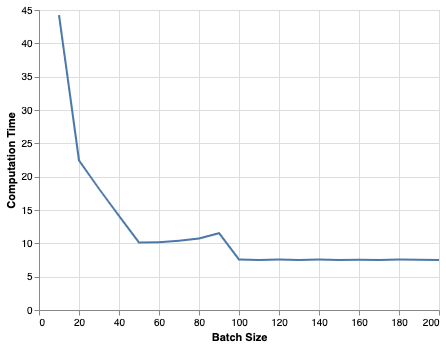

In [17]:
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Computation Time': times
})
alt.Chart(time_df).mark_line().encode(
    alt.X('Batch Size:Q'),
    alt.Y('Computation Time:Q')
)